Missing dates in Bulwary data: 0
        Date  Bulwary  Opady
0 2016-11-18      421    0.0
1 2016-11-19      328    3.2
2 2016-11-20      539    0.0
3 2016-11-21     1002    0.0
4 2016-11-22     1132    0.0


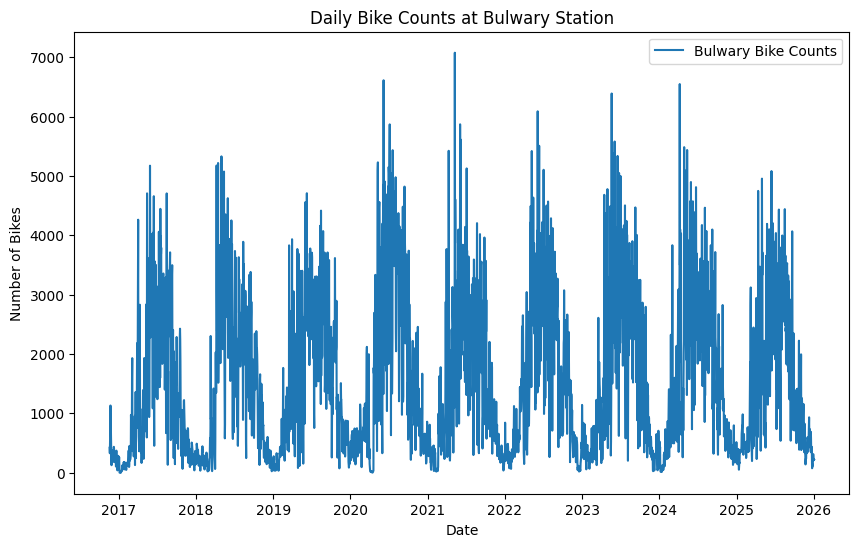

In [5]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('bikes.csv')

data_bulwary = pd.DataFrame({'Date': data['Date'], 'Bulwary': data['Bulwary'], 'Opady': data['Suma dobowa opadów [mm]']})
data_bulwary['Date'] = pd.to_datetime(data_bulwary['Date'], format='%Y-%m-%d')

missing_dates = data_bulwary['Bulwary'].isnull().sum()
print(f'Missing dates in Bulwary data: {missing_dates}')

print(data_bulwary.head())

plt.figure(figsize=(10, 6))
plt.plot(data_bulwary['Date'], data_bulwary['Bulwary'], label='Bulwary Bike Counts')
plt.xlabel('Date')
plt.ylabel('Number of Bikes')
plt.title('Daily Bike Counts at Bulwary Station')
plt.legend()
plt.show()  

13:07:25 - cmdstanpy - INFO - Chain [1] start processing
13:07:25 - cmdstanpy - INFO - Chain [1] done processing


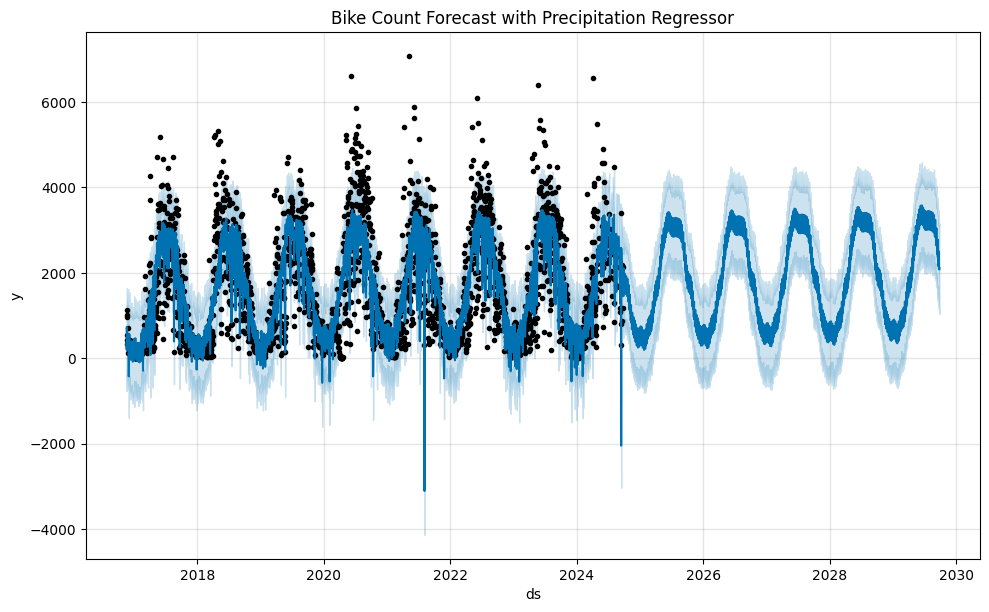

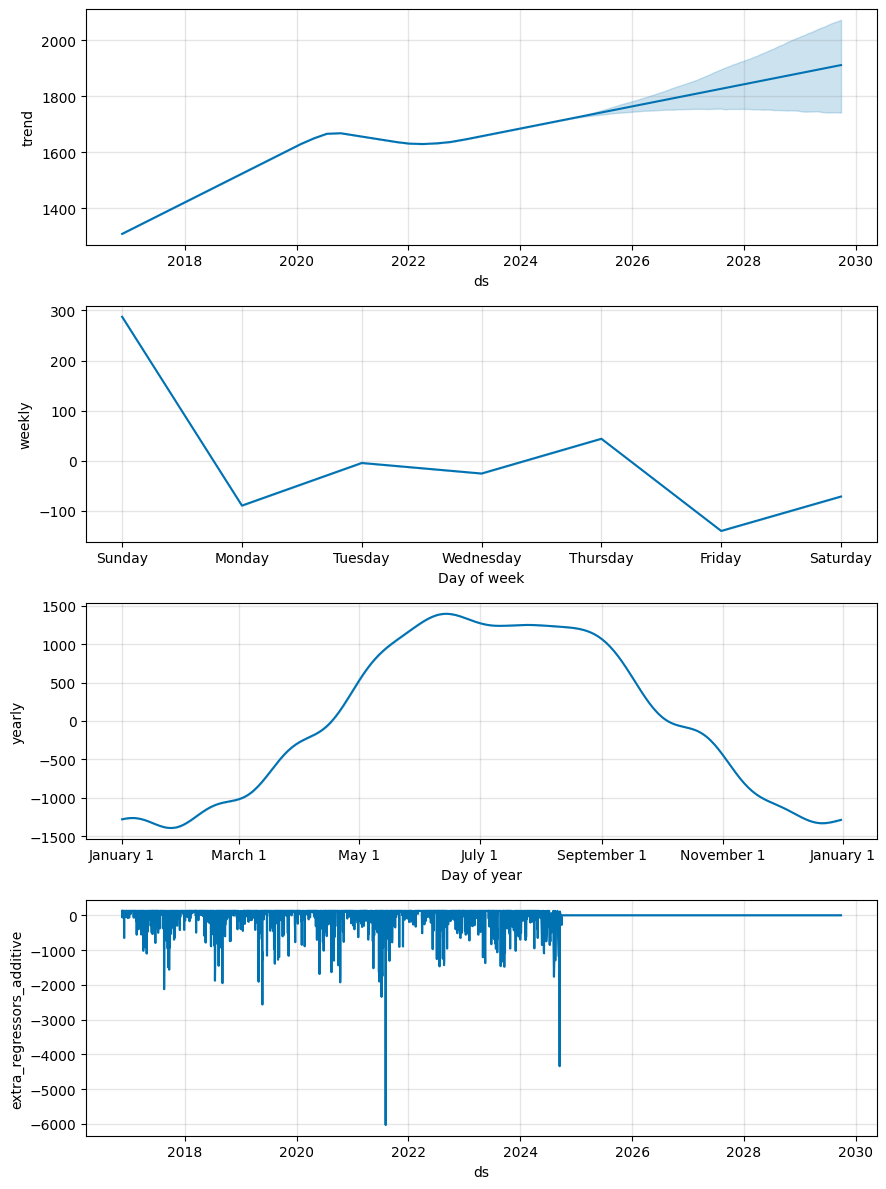

In [26]:
# Prepare data for Prophet with regressor
df_prophet = data_bulwary.rename(columns={'Date': 'ds', 'Bulwary': 'y', 'Opady': 'opady'})
df_prophet = df_prophet.dropna(subset=['y', 'opady'])
m = Prophet()
m.add_regressor('opady', prior_scale=10)
m.fit(df_prophet)
future = m.make_future_dataframe(periods=5*365)
historical_opady = df_prophet.set_index('ds')['opady']
future['opady'] = future['ds'].map(historical_opady).fillna(df_prophet['opady'].mean())
forecast = m.predict(future)
fig1 = m.plot(forecast)
plt.title('Bike Count Forecast with Precipitation Regressor')
plt.show()
fig2 = m.plot_components(forecast)
plt.show()

Correlation between Bulwary bike counts and precipitation: -0.12508437249814214


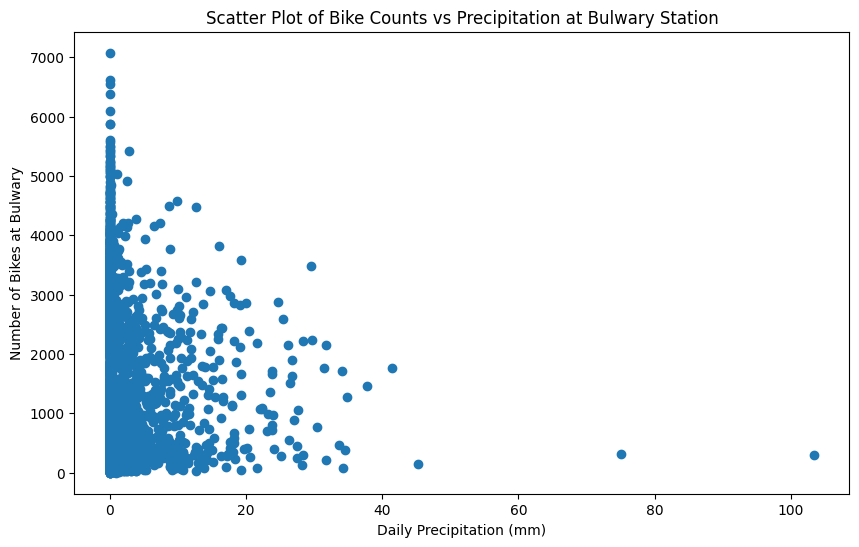

In [8]:
correlation = data_bulwary[['Bulwary', 'Opady']].corr()
print(f'Correlation between Bulwary bike counts and precipitation: {correlation.iloc[0,1]}')


plt.figure(figsize=(10, 6))
plt.scatter(data_bulwary['Opady'], data_bulwary['Bulwary'])
plt.xlabel('Daily Precipitation (mm)')
plt.ylabel('Number of Bikes at Bulwary')
plt.title('Scatter Plot of Bike Counts vs Precipitation at Bulwary Station')
plt.show()

Macierz korelacji:
              Bulwary  Opady  Temp_srednia  Temp_max  Temp_min
Bulwary         1.000 -0.125         0.781     0.820     0.669
Opady          -0.125  1.000         0.134     0.081     0.197
Temp_srednia    0.781  0.134         1.000     0.974     0.966
Temp_max        0.820  0.081         0.974     1.000     0.893
Temp_min        0.669  0.197         0.966     0.893     1.000


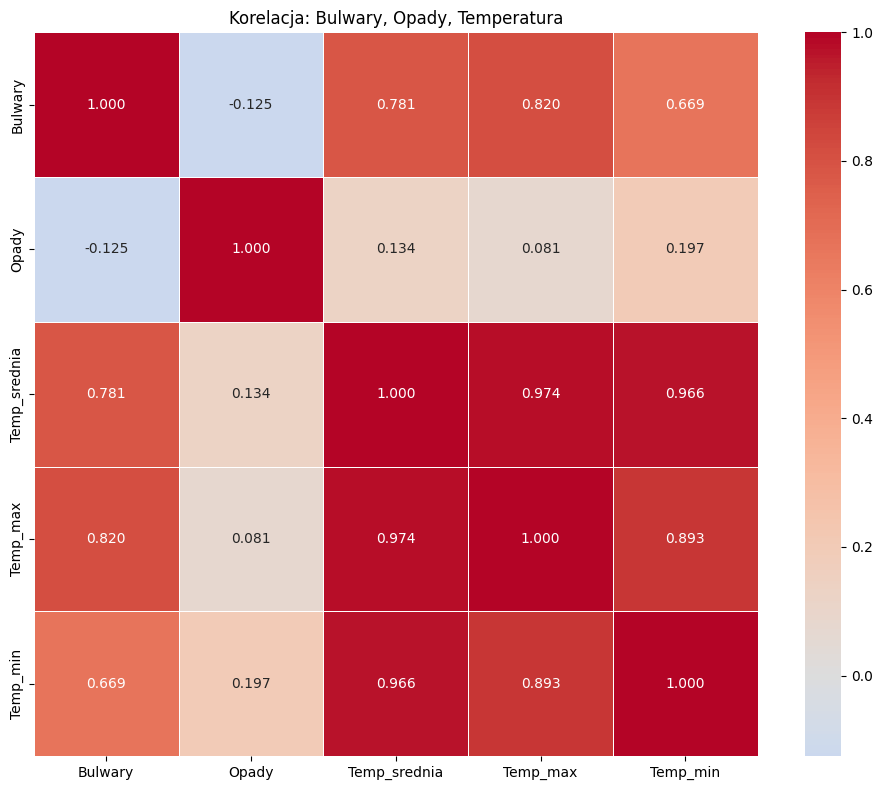

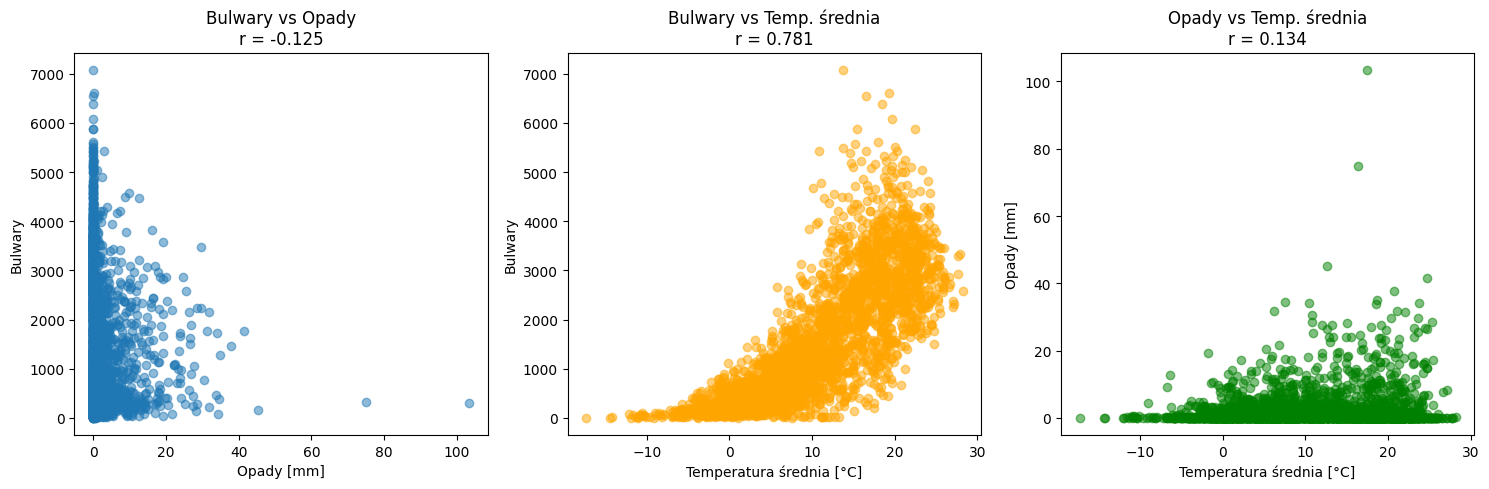


Podsumowanie korelacji z Bulwary:
  - Opady: -0.125 (ujemna - więcej opadów = mniej rowerzystów)
  - Temp. średnia: 0.781 (dodatnia - cieplej = więcej rowerzystów)
  - Temp. max: 0.820
  - Temp. min: 0.669


In [27]:
# Analiza korelacji: Bulwary, Opady, Temperatura
import seaborn as sns
import numpy as np

# Przygotowanie danych z temperaturą
data_korelacja = pd.DataFrame({
    'Bulwary': data['Bulwary'],
    'Opady': data['Suma dobowa opadów [mm]'],
    'Temp_srednia': data['Średnia temperatura dobowa [°C]'],
    'Temp_max': data['Maksymalna temperatura dobowa [°C]'],
    'Temp_min': data['Minimalna temperatura dobowa [°C]']
})

# Usunięcie brakujących wartości
data_korelacja = data_korelacja.dropna()

# Macierz korelacji
correlation_matrix = data_korelacja.corr()
print("Macierz korelacji:")
print(correlation_matrix.round(3))

# Wizualizacja heatmapy
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.3f', square=True, linewidths=0.5)
plt.title('Korelacja: Bulwary, Opady, Temperatura')
plt.tight_layout()
plt.show()

# Wykresy rozrzutu
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(data_korelacja['Opady'], data_korelacja['Bulwary'], alpha=0.5)
axes[0].set_xlabel('Opady [mm]')
axes[0].set_ylabel('Bulwary')
axes[0].set_title(f'Bulwary vs Opady\nr = {correlation_matrix.loc["Bulwary", "Opady"]:.3f}')

axes[1].scatter(data_korelacja['Temp_srednia'], data_korelacja['Bulwary'], alpha=0.5, color='orange')
axes[1].set_xlabel('Temperatura średnia [°C]')
axes[1].set_ylabel('Bulwary')
axes[1].set_title(f'Bulwary vs Temp. średnia\nr = {correlation_matrix.loc["Bulwary", "Temp_srednia"]:.3f}')

axes[2].scatter(data_korelacja['Temp_srednia'], data_korelacja['Opady'], alpha=0.5, color='green')
axes[2].set_xlabel('Temperatura średnia [°C]')
axes[2].set_ylabel('Opady [mm]')
axes[2].set_title(f'Opady vs Temp. średnia\nr = {correlation_matrix.loc["Opady", "Temp_srednia"]:.3f}')

plt.tight_layout()
plt.show()

print("\nPodsumowanie korelacji z Bulwary:")
print(f"  - Opady: {correlation_matrix.loc['Bulwary', 'Opady']:.3f} (ujemna - więcej opadów = mniej rowerzystów)")
print(f"  - Temp. średnia: {correlation_matrix.loc['Bulwary', 'Temp_srednia']:.3f} (dodatnia - cieplej = więcej rowerzystów)")
print(f"  - Temp. max: {correlation_matrix.loc['Bulwary', 'Temp_max']:.3f}")
print(f"  - Temp. min: {correlation_matrix.loc['Bulwary', 'Temp_min']:.3f}")